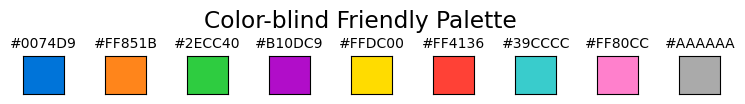

In [1]:
import re
import os
import sys
import torch
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['font.weight'] = 'normal' 
plt.rcParams['font.size'] = 14

from tqdm import tqdm
from dataclasses import dataclass
from pathlib import Path
from scipy.interpolate import interp1d
from collections import defaultdict
from matplotlib.patches import FancyBboxPatch
from mpl_toolkits.axisartist.axislines import AxesZero

HOME = Path.cwd().parent
sys.path.append(str(HOME))

from src.data import BatteryData
from src.builders import MODELS
from src.utils import import_config

pd.options.display.precision = 1
palette = [
    '#0074D9',  # blue
    '#FF851B',  # orange
    '#2ECC40',  # green
    '#B10DC9',  # purple
    '#FFDC00',  # yellow
    '#FF4136',  # red
    '#39CCCC',  # teal
    '#FF80CC',  # pink
    '#AAAAAA',  # gray
]
# Show palette
fig, axes = plt.subplots(1, len(palette), figsize=(len(palette), 0.5))
for color, ax in zip(palette, axes):
    ax.set_facecolor(color)
    ax.set_title(color, fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])
fig.suptitle('Color-blind Friendly Palette', y=1.8)
plt.subplots_adjust(wspace=1, hspace=1)
plt.show()

Reproduce Figure 1a

In [2]:
path = (HOME / 'data/processed/').glob('*/*')
all_batteries = [
    BatteryData.load(p) for p in tqdm(
        list(path), desc='Load cells'
    )
]
material_map = defaultdict(list)
for cell in all_batteries:
    material_map[cell.cathode_material].append(cell)

Load cells: 100%|██████████| 411/411 [08:12<00:00,  1.20s/it]


In [3]:
cycle = 99
# delete cells whose cycle length is less than 99
for dataset_name, dataset_values in material_map.items():
    total_len = len(dataset_values)
    for cell_idx, cell_value in enumerate(dataset_values[::-1]):
        if len(cell_value.cycle_data) < cycle:
            del material_map[dataset_name][total_len-cell_idx-1]


In [4]:
settings_df = pd.read_csv(HOME / 'data/settings.csv').set_index(pd.Series([
    'CALCE', 'HNEI', 'HUST',
    'MATR-1', 'MATR-2', 'NE', 'CLO', 'MATR-Full',
    'RWTH', 'SNL', 'UL-PUR',
    'This Work'
], name='Dataset')).drop('Unnamed: 0', axis=1)
settings_df

,#cells,#materials,#charge_protocols,#discharge_protocols,#temperatures,#form_factors,#different_settings
Dataset,,,,,,,
CALCE,13,1,1,2,1,1,2
HNEI,14,1,1,1,1,1,1
HUST,77,1,1,77,1,1,77
MATR-1,84,1,61,1,1,1,61
MATR-2,81,1,47,1,1,1,47
NE,135,1,69,1,1,1,69
CLO,45,1,9,1,1,1,9
MATR-Full,178,1,78,1,1,1,78
RWTH,48,1,1,1,1,1,1


Note that the texts are added in Powerpoint. Here we just plot the figure itself.

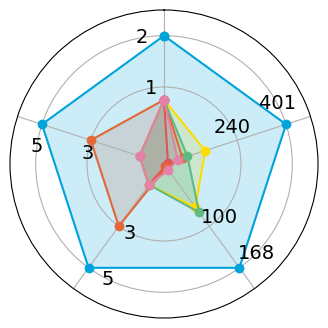

In [ ]:
datasets_to_plot = ['CALCE', 'NE', 'SNL', 'HUST', 'CLO', 'This Work']
df = settings_df[['#form_factors', '#materials', '#temperatures', '#cells']]
df = df.assign(**{
    '#work_conds': settings_df['#charge_protocols'] \
        + settings_df['#discharge_protocols']})
ordered_columns = [
    '#form_factors', '#materials', '#temperatures', '#work_conds', '#cells']
df = df.loc[:, ordered_columns]

def plot_completed(ax, angles, data, line_type, color, label):
    complete_angles = np.concatenate((angles, [angles[0]]))
    complete_data = np.concatenate((data, [data.iloc[0]]))
    ax.plot(complete_angles, complete_data, line_type, color=color, label=label)
    ax.fill(complete_angles, complete_data, color=color, alpha=0.2)

fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(projection='polar')
angles = np.linspace(0, 2*np.pi, len(ordered_columns), endpoint=False)
ticklabels = [
    ('Form\nFactors', 1.5),
    ('Materials', 1.35),
    ('Temperatures', 1.45),
    ('Working\nconditions', 1.3),
    ('Total\nCells', 1.5),
]
levels = [0.6, 1.0]
maxes = df.max(axis=0)

colors = ['#00A3DA', '#E780A9', '#61B984','#E26837',  '#FFDC00', '#DF5555'][::-1]

for dataset, color in zip(datasets_to_plot, colors):
    to_plot = df.loc[dataset] / maxes
    plot_completed(ax, angles, to_plot, 'o-', color, label=dataset)
    ax.set_thetagrids(angles * 180/np.pi, df.columns)
    ax.set_theta_zero_location("N")
    ax.set_rgrids(levels, labels=[])
    ax.set_ylim([0, 1.2])
    ax.set_xticklabels([])
#     ax.legend(
#         ncols=3, fontsize=11,
#         columnspacing=1,
#         loc=(-0.05, -0.35),
#         frameon=False)
# Add the text for radar chart, to avoid the bold font problem
# for angle, (label, y) in zip(angles, ticklabels):
#     ax.text(angle, y, label, ha='center', va='center')

for angle, max_ in zip(angles, maxes.values):
    angle = angle + np.pi / 18
    for l in levels:
        ax.text(angle, l, str(int(max_ * l)), ha='center', va='center')
plt.draw()
os.makedirs(HOME / 'results/figures/fig1', exist_ok=True) 

fig.savefig(
    HOME / 'results/figures/fig1/dataset_radar.svg',
    bbox_inches='tight',
    pad_inches=0.1,
    transparent=True)
fig.show()

Reproduce Figure 1b

In [6]:
# Helper functions
def get_V_of_Qd(cycle_data, C, interp_dims=1000, mode='discharge', xe=1.):
    I = np.array(cycle_data.current_in_A)  # noqa
    V = np.array(cycle_data.voltage_in_V)
    Qc = np.array(cycle_data.charge_capacity_in_Ah) / C
    Qd = np.array(cycle_data.discharge_capacity_in_Ah) / C

    charge_mask, discharge_mask = I > 0.1, I < -0.1
    Qc, Qd = Qc[charge_mask], Qd[discharge_mask]
    Ic, Id = I[charge_mask], I[discharge_mask]
    Vc, Vd = V[charge_mask], V[discharge_mask]
    # V(Qc), V(Qd), I(Qc), I(Qd)
    res = interpolate( Qd, Vd, interp_dims, mode, 0., xe)
    return res

def get_features(cycle_data, C, interp_dims=1000, xe=1.):
    I = np.array(cycle_data.current_in_A)  # noqa
    V = np.array(cycle_data.voltage_in_V)
    Qc = np.array(cycle_data.charge_capacity_in_Ah) / C
    Qd = np.array(cycle_data.discharge_capacity_in_Ah) / C

    charge_mask, discharge_mask = I > 0.1, I < -0.1
    Qc, Qd = Qc[charge_mask], Qd[discharge_mask]
    Ic, Id = I[charge_mask], I[discharge_mask]
    Vc, Vd = V[charge_mask], V[discharge_mask]
    # V(Qc), V(Qd), I(Qc), I(Qd)
    cycle_feature = [
        interpolate(
            Qc, Vc, interp_dims, 'charge', xe=xe),
        interpolate(
            Qd, Vd, interp_dims, 'discharge', xe=xe),
        interpolate(Qc, Ic, interp_dims, xe=xe),
        interpolate(Qd, Id, interp_dims, xe=xe),
    ]
    # delta_V(Q)
    cycle_feature.append(
        cycle_feature[0] - cycle_feature[1][::-1]
    )
    # R(Q)
    cycle_feature.append(
        (cycle_feature[0] - cycle_feature[1][::-1])
        / (cycle_feature[2] - cycle_feature[3][::-1] + 1e-3)
    )
    return np.stack(cycle_feature)

def interpolate(x, y, interp_dims, fill_type='', xs=0, xe=1.):
    if len(x) <= 2:
        return np.zeros(interp_dims)
    mask = (x >= xs) & (x <= xe)
    x, y = x[mask], y[mask]
    if fill_type == 'charge':
        fill_values = (y.min(), y.max())
    elif fill_type == 'discharge':
        fill_values = (y.max(), y.min())
    else:
        fill_values = float('nan')
    func = interp1d(
        x, y,
        kind='linear',
        bounds_error=False,
        fill_value=fill_values)
    return func(np.linspace(xs, xe, interp_dims))

def get_cycle_life(cell_data, ths=0.8):
    ths = cell_data.nominal_capacity_in_Ah * ths
    for i in range(len(cell_data.cycle_data)):
        if max(cell_data.cycle_data[i].discharge_capacity_in_Ah) <= ths:
            break
    return i

  5%|▌         | 22/411 [00:00<00:04, 92.78it/s] 

100%|██████████| 411/411 [00:24<00:00, 16.90it/s] 


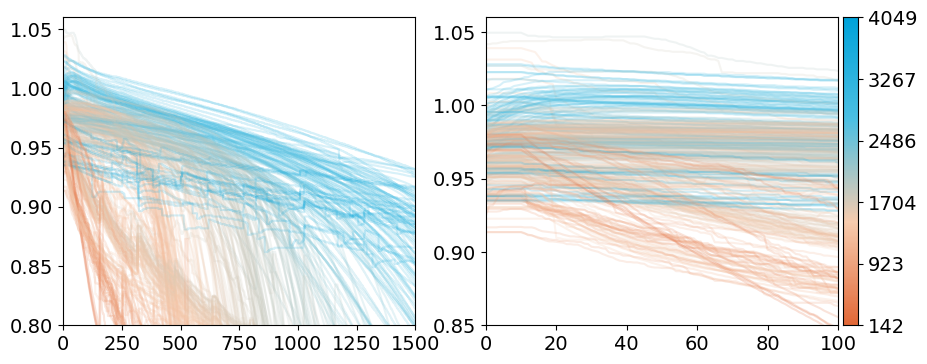

In [7]:
from scipy.signal import medfilt 
from matplotlib.colors import LinearSegmentedColormap

colors = ['#E26837', '#F7CCAE', '#4DC0E3', '#00A3DA'] 
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)
max_ = 4049
min_ = 142

compare_cells = material_map['LCO']
cycle_lives = [get_cycle_life(x, 0.9) for x in compare_cells]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

for battery in tqdm(all_batteries):
    capacities = np.array([
        max(x.discharge_capacity_in_Ah) for x in battery.cycle_data
    ])
    if len(capacities) < 200:
        continue
    cycle_life = get_cycle_life(battery)
    capacities = medfilt(capacities, 21) / battery.nominal_capacity_in_Ah
    if capacities[:10].mean() > 1.05:
        capacities /= 1.1
    score = (cycle_life - min_) / (max_ - min_)
    score = score ** 0.5
    color = cmap(score)
    # zorder = int(3 * (1 - score))
    zorder = 1
    ax1.plot(capacities, color=color, alpha=0.2, zorder=zorder)
    ax2.plot(capacities, color=color, alpha=0.2, zorder=zorder)
    cycle_lives.append(cycle_life)
ax1.set_ylim([0.8, 1.06])
ax1.set_xlim([0, 1500])
ax2.set_ylim([0.85, 1.06])
ax2.set_xlim([0, 100])
# plt.colorbar()
cax = ax2.inset_axes([1.01, 0, 0.05, 1.])
cax.yaxis.tick_right()
cax.yaxis.set_label_position('right')
cax.set_xticks([])
img = torch.linspace(1, 0, 1000)[None].T.expand(-1, 50)
cax.imshow(img, cmap=cmap)
yticks = [0, 200, 400, 600, 800, 1000]
labels = [int((x/1000) * (max_ - min_) + min_) for x in yticks]
cax.set_yticks(yticks, labels=labels[::-1])

fig.savefig(
    HOME / 'results/figures/fig1/1b_dataset.svg',
    bbox_inches='tight',
    pad_inches=0.1
)
plt.show()

Reproduce Figure 2 elements.

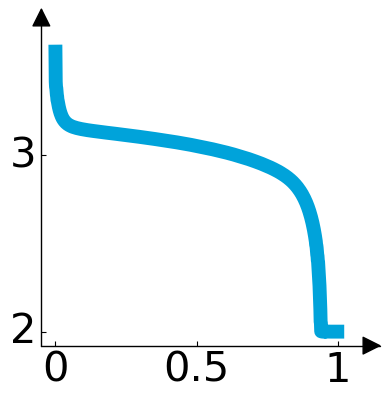

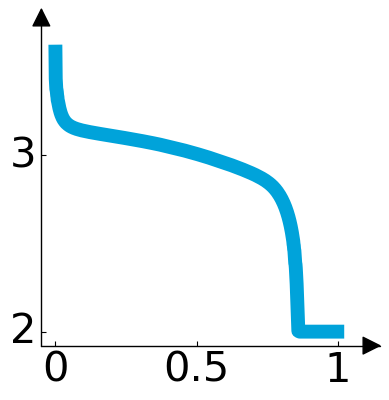

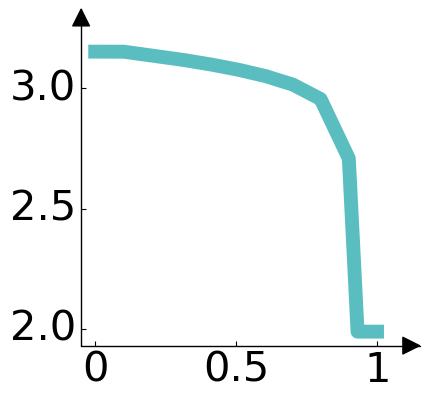

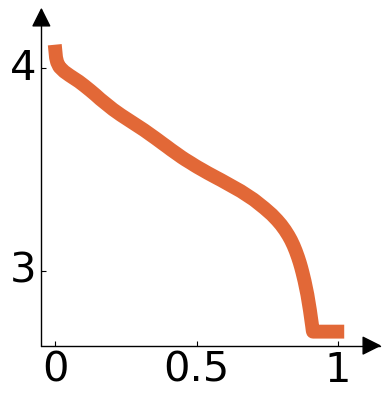

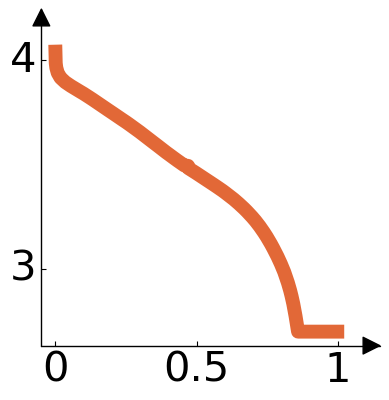

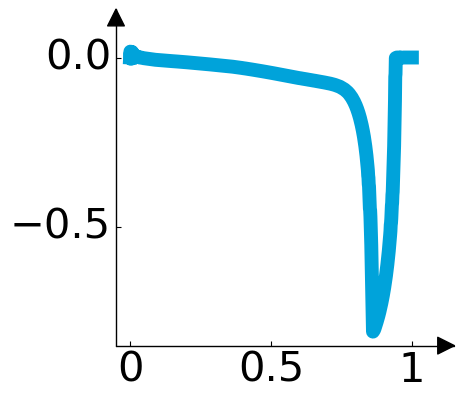

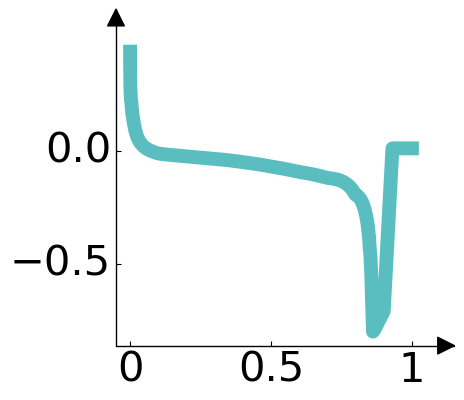

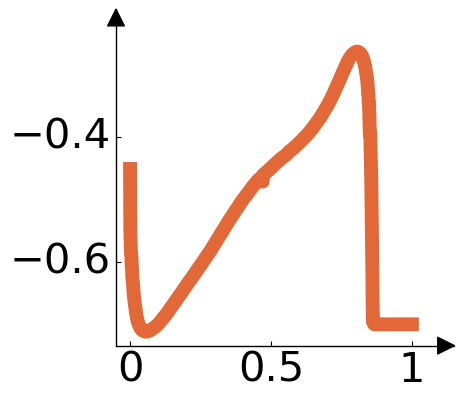

In [8]:
lfp_min_cell, lfp_max_cell = None, None
for cell in material_map['LFP']:
    if lfp_max_cell is None or len(cell.cycle_data) > len(lfp_max_cell.cycle_data):
        lfp_max_cell = cell
    if lfp_min_cell is None or len(cell.cycle_data) < len(lfp_min_cell.cycle_data):
        lfp_min_cell = cell
lco_cell = list(sorted(
    material_map['LCO'], key=lambda x: x.cell_id
))[-7]

lfp_min_feat_10 = get_V_of_Qd(
    lfp_min_cell.cycle_data[9], lfp_min_cell.nominal_capacity_in_Ah)
lfp_min_feat_100 = get_V_of_Qd(
    lfp_min_cell.cycle_data[99], lfp_min_cell.nominal_capacity_in_Ah)
lfp_max_feat_100 = get_V_of_Qd(
    lfp_max_cell.cycle_data[99], lfp_max_cell.nominal_capacity_in_Ah)
lco_feat_10 = get_V_of_Qd(
    lco_cell.cycle_data[9], lco_cell.nominal_capacity_in_Ah)
lco_feat_100 = get_V_of_Qd(
    lco_cell.cycle_data[99], lco_cell.nominal_capacity_in_Ah)

plt.rcParams['font.size'] = 30
methods = [
    'lfp_min_feat_10',
    'lfp_min_feat_100',
    'lfp_max_feat_100',
    'lco_feat_10',
    'lco_feat_100',
    'lfp_min_feat_100-lfp_min_feat_10',
    'lfp_min_feat_100-lfp_max_feat_100',
    'lfp_min_feat_100-lco_feat_100',
    ]
colors = ['#00A3DA', '#00A3DA', '#5ABEC1', '#E26837', '#E26837',
          '#00A3DA', '#5ABEC1', '#E26837']
for method, color in zip(methods, colors):
    curve = eval(method)
    fig= plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(axes_class=AxesZero)
    ax.plot(curve, color=color, linewidth=10)
    plt.xticks([0, 500, 1000], ['0', '0.5', '1'])
    ax.axis['bottom'].set_axisline_style('-|>')
    ax.axis['left'].set_axisline_style('-|>')
    ax.axis['top'].set_visible(False)
    ax.axis['right'].set_visible(False)
    if method == 'lco_feat_100':
        ax.set_yticks([3, 4])
    os.makedirs(HOME / 'results/figures/fig2', exist_ok=True) 
    fig.savefig(HOME / f'results/figures/fig2/2a_{method}.svg',
                bbox_inches='tight', pad_inches=0.1)
    plt.show()

plt.rcParams['font.size'] = 14

In [9]:
def get_datasource(cell: BatteryData):
    datasource, cell_id = cell.cell_id.split('_', 1)

    if datasource == 'MATR':
        indx = int(cell_id[1]) - 1
        datasource += matr_batch_names[indx]

    elif datasource == 'SNL':
        mean_temp = np.nanmean(cell.cycle_data[0].temperature_in_C)
        if mean_temp < 20:
            datasource = 'SNL-temp-18C'
        elif mean_temp < 30:
            datasource = 'SNL-temp-26C'
        else:
            datasource = 'SNL-temp-36C'

    return datasource

matr_batch_names = ['-2017-05', '-2017-06', '-2018-04', '-2019-01']
markers = iter(['o', '*', 'd', 's', 'P', '1', 'x', (6, 2, 0)])

ds_to_marker = {}
for cell in material_map['LFP']:
    datasource = get_datasource(cell)
    if datasource not in ds_to_marker:
        ds_to_marker[datasource] = next(markers)

ds_to_marker

/tmp/ipykernel_3541125/1906725357.py:9: RuntimeWarning: Mean of empty slice
  mean_temp = np.nanmean(cell.cycle_data[0].temperature_in_C)


{'HUST': 'o',
 'MATR-2017-05': '*',
 'MATR-2017-06': 'd',
 'MATR-2018-04': 's',
 'MATR-2019-01': 'P',
 'SNL-temp-18C': '1',
 'SNL-temp-26C': 'x',
 'SNL-temp-36C': (6, 2, 0)}

Process LFP cells:  92%|█████████▏| 254/275 [00:03<00:00, 103.78it/s]/tmp/ipykernel_3541125/1906725357.py:9: RuntimeWarning: Mean of empty slice
  mean_temp = np.nanmean(cell.cycle_data[0].temperature_in_C)
Process LFP cells: 100%|██████████| 275/275 [00:03<00:00, 75.35it/s] 


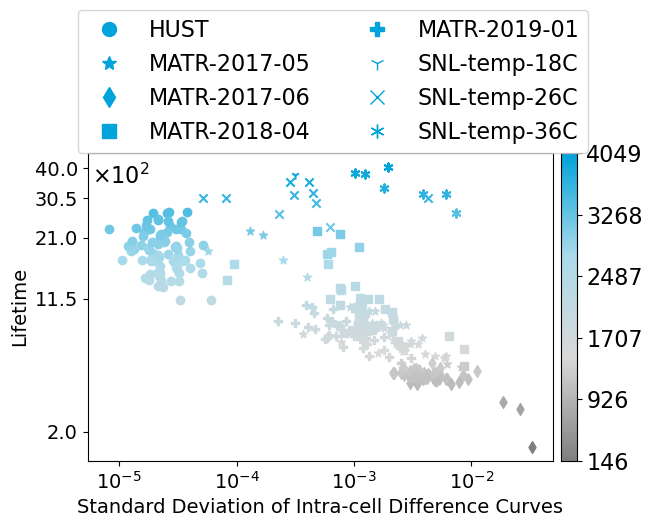

In [10]:
from matplotlib.colors import LinearSegmentedColormap

colors = ['#7F7F7F', '#D9D9D9', '#ABDBEB', '#00A3DA'] 
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
plt.rcParams['font.size'] = 16
vars_, labels, markers = [], [], []
for cell in tqdm(material_map['LFP'], desc='Process LFP cells'):
    q10 = get_V_of_Qd(cell.cycle_data[9], cell.nominal_capacity_in_Ah)
    q100 = get_V_of_Qd(cell.cycle_data[99], cell.nominal_capacity_in_Ah)
    var = np.var(q100 - q10)
    label = get_cycle_life(cell)
    vars_.append(np.log10(var))
    labels.append(label)
    markers.append(ds_to_marker[get_datasource(cell)])
max_labels, min_labels = max(labels), min(labels)
labels = np.array(labels)
labels = np.log10(labels - min_labels + 400)
yticks = np.linspace(200, 4000, 5)
yticks = np.log10(yticks - min_labels + 400)
gap = labels.max() - labels.min()
for var, label, marker in zip(vars_, labels, markers):
    ax.scatter(var, label, color=cmap((label - labels.min()) / gap), marker=marker)
ax.set_yticks(yticks, labels=[round(10**y-400+min_labels)/100 for y in yticks])
x_pos = ax.get_xlim()[0] + (ax.get_xlim()[1] - ax.get_xlim()[0]) * 1e-2
y_pos = ax.get_ylim()[1] - (ax.get_ylim()[1] - ax.get_ylim()[0]) / 10
ax.text(x_pos, y_pos, '$\\times 10^2$')

xticks = [-2, -3, -4, -5]
ax.set_xticks(xticks, [f'$10^{{{x}}}$' for x in xticks])

handles = []
labels = []
for category, marker in ds_to_marker.items():
    handle = plt.Line2D(
        [0], [0],
        marker=marker,
        linestyle='none',
        markeredgecolor=colors[-1],
        markerfacecolor=colors[-1],
        markersize=10
    )
    handles.append(handle)
    labels.append(category)

# Add the legend
ax.legend(handles, labels, bbox_to_anchor=(1.1, 1.5), ncols=2)
ax.set_ylabel('Lifetime')
ax.set_xlabel('Standard Deviation of Intra-cell Difference Curves')

# For color bar
cax = ax.inset_axes([1.01, 0, 0.05, 1.])
cax.yaxis.tick_right()
cax.yaxis.set_label_position('right')
cax.set_xticks([])
img = torch.linspace(1, 0, 1000)[None].T.expand(-1, 50)
cax.imshow(img, cmap=cmap)
yticks = [0, 200, 400, 600, 800, 1000]
labels = [
    int((x/1000) * (max_labels - min_labels) + min_labels) for x in yticks]
cax.set_yticks(yticks, labels=labels[::-1])
fig.savefig(
    HOME / f'results/figures/fig2/2b_intra_diff_with_marker.svg',
    bbox_inches='tight', pad_inches=0.1)
os.makedirs(HOME / 'results/figures/supp1', exist_ok=True) 
fig.savefig(
    HOME / f'results/figures/supp1/intra_diff_with_marker.svg',
    bbox_inches='tight', pad_inches=0.1)
plt.show()

Process LFP cells:  92%|█████████▏| 253/275 [00:03<00:00, 101.15it/s]/tmp/ipykernel_3541125/1906725357.py:9: RuntimeWarning: Mean of empty slice
  mean_temp = np.nanmean(cell.cycle_data[0].temperature_in_C)
Process LFP cells: 100%|██████████| 275/275 [00:03<00:00, 76.47it/s] 


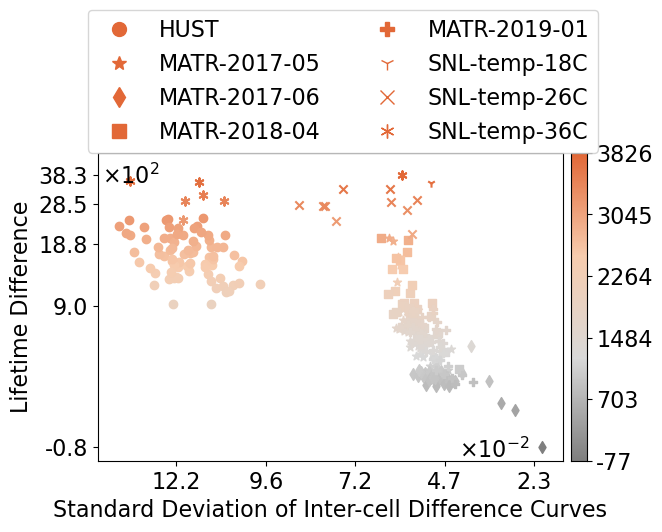

In [11]:
from matplotlib.colors import LinearSegmentedColormap
colors = ['#7F7F7F', '#D9D9D9', '#F7CCAE', '#E26837'] 
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

cycle = 99
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
plt.rcParams['font.size'] = 16
vars_, labels, markers = [], [], []

base_cell = list(sorted(
    material_map['LCO'], key=lambda x: x.cell_id
))[-7]
base_100 = get_V_of_Qd(
    base_cell.cycle_data[cycle], base_cell.nominal_capacity_in_Ah)
base_label = get_cycle_life(base_cell)

for cell in tqdm(material_map['LFP'], desc='Process LFP cells'):
    label_diff = get_cycle_life(cell) - base_label
    q100 = get_V_of_Qd(cell.cycle_data[cycle], cell.nominal_capacity_in_Ah)
    feat = (q100 - base_100)
    signed_var = np.sign(np.median(feat)) * np.log10(np.var(feat) + 1)
    # signed_var = np.log10(np.var(feat) + 1)
    vars_.append(signed_var)
    labels.append(label_diff)
    markers.append(ds_to_marker[get_datasource(cell)])
max_labels, min_labels = max(labels), min(labels)
labels = np.array(labels)
labels = np.log10(labels - min_labels + 400)
gap = labels.max() - labels.min()
for var, label, marker in zip(vars_, labels, markers):
    ax.scatter(var, label, color=cmap((label - labels.min()) / gap), marker=marker)
yticks = np.linspace(min_labels, max_labels, 5)
yticks = np.log10(yticks - min_labels + 400)
ytick_labels = [round(10**y-400+min_labels)/100 for y in yticks]
ax.set_yticks(yticks, labels=[f'{y:.1f}' for y in ytick_labels])
ax.set_ylim([ax.get_ylim()[0], labels.max() * 1.023])
x_pos = ax.get_xlim()[0] + (ax.get_xlim()[1] - ax.get_xlim()[0]) * 1e-2
y_pos = ax.get_ylim()[1] - (ax.get_ylim()[1] - ax.get_ylim()[0]) / 10
ax.text(x_pos, y_pos, '$\\times 10^2$')
xticks = [-0.05, -0.04, -0.03, -0.02, -0.01]
xtick_labels = [10**(-x)-1 for x in xticks]
ax.set_xticks(xticks, labels=[f'{x*100:.1f}'for x in xtick_labels])
x_pos = ax.get_xlim()[1] - (ax.get_xlim()[1] - ax.get_xlim()[0]) / 4.5
y_pos = ax.get_ylim()[0] + (ax.get_ylim()[1] - ax.get_ylim()[0]) * 1e-2
ax.text(x_pos, y_pos, '$\\times10^{{-2}}$')

handles = []
labels = []
for category, marker in ds_to_marker.items():
    handle = plt.Line2D(
        [0], [0],
        marker=marker,
        linestyle='none',
        markeredgecolor=colors[-1],
        markerfacecolor=colors[-1],
        markersize=10
    )
    handles.append(handle)
    labels.append(category)

# Add the legend
ax.legend(handles, labels, bbox_to_anchor=(1.1, 1.5), ncols=2)
ax.set_ylabel('Lifetime Difference')
ax.set_xlabel('Standard Deviation of Inter-cell Difference Curves')

# For color bar
cax = ax.inset_axes([1.01, 0, 0.05, 1.])
cax.yaxis.tick_right()
cax.yaxis.set_label_position('right')
cax.set_xticks([])
img = torch.linspace(1, 0, 1000)[None].T.expand(-1, 50)
cax.imshow(img, cmap=cmap)
yticks = [0, 200, 400, 600, 800, 1000]
labels = [
    int((x/1000) * (max_labels - min_labels) + min_labels) for x in yticks]
cax.set_yticks(yticks, labels=labels[::-1])
fig.savefig(HOME / f'results/figures/fig2/2b_inter_diff_with_marker.svg',
            bbox_inches='tight', pad_inches=0.1)
os.makedirs(HOME / 'results/figures/supp2', exist_ok=True) 
fig.savefig(
    HOME / f'results/figures/supp2/inter_diff_with_marker.svg',
    bbox_inches='tight', pad_inches=0.1)
plt.show()

Reproduce Figure 3.

In [12]:
# Helper functions
def format_scores(scores, show_max_min: bool = True):
    mean = np.mean(scores)
    std = np.std(scores)
    if show_max_min:
        min_ = np.min(scores)
        max_ = np.max(scores)
        return f'{mean:.0f}±{std:.0f}'
    else:
        return f'{mean:.0f}±{std:.0f}'

def format_df(res_dict, agg_fn):
    new_res = {
        k: {
            key: agg_fn(val) for key, val in v.items()
        } for k, v in res_dict.items()
    }
    return pd.DataFrame(new_res)

def extract_scores(log_filename):
    with open(log_filename, 'r') as f:
        last_line = f.read().splitlines()[-1]
    scores = {}
    try:
        rmse, mae, mape = re.findall(r'[^:]+: (\d+\.\d+)', last_line)
    except:
        print(log_filename, last_line)
        raise
    scores['RMSE'] = float(rmse) 
    scores['MAE'] = float(mae)
    scores['MAPE'] = float(mape) * 100
    return scores

In [13]:
workspace = HOME / 'workspaces'
datasets_to_use = ['matr_1', 'matr_2', 'hust', 'mix_100', 'mix_20']
sklearn_baseline_names = [
    'dummy',
    'variance_model',
    'discharge_model',
    'full_model',
    'ridge',
    'pcr',
    'plsr',
    'svm',
    'rf'
]
nn_baseline_names = ['mlp', 'cnn', 'lstm']

def collect_results(dataset):
    sklearn_results = [
        sklearn_baselines[dataset][name] for name in sklearn_baseline_names
    ]
    nn_results = [
        nn_baselines[dataset][name] for name in nn_baseline_names
    ]
    our_results = [ours[dataset]['Ours']]
    return sklearn_results + nn_results + our_results

sklearn_baselines = defaultdict(dict)
for method_path in workspace.glob('baselines/sklearn/*'):
    method = method_path.name
    for dataset_res in method_path.glob('*'):
        dataset = dataset_res.name
        score = extract_scores(dataset_res / 'log.0')['RMSE']
        # score = min(score, 2000)  # For better visualizability
        sklearn_baselines[dataset][method] = score

nn_baselines = defaultdict(dict)
for method_path in workspace.glob('baselines/nn_models/*'):
    method = method_path.name
    for dataset_res in method_path.glob('*'):
        dataset = dataset_res.name
        scores = []
        for i in range(8):
            score = extract_scores(dataset_res / f'log.{i}')['RMSE']
            if score < 2000:  # For better visibility of CNN on MIX-20
                scores.append(score)
        nn_baselines[dataset][method] = scores
ours = defaultdict(dict)

method = 'Ours'
for dataset_res in workspace.glob('ablation/diff_branch/batlinet/*'):
    dataset = dataset_res.name
    try:
        scores = []
        for i in range(8):
            score = extract_scores(dataset_res / f'log.{i}')['RMSE']
            scores.append(score)
        ours[dataset][method] = scores
    except:
        ours[dataset][method] = 'none'

sklearn_baselines['matr_1']['variance_model'] = 138
sklearn_baselines['matr_2']['variance_model'] = 196
sklearn_baselines['matr_1']['discharge_model'] = 86
sklearn_baselines['matr_2']['discharge_model'] = 173
sklearn_baselines['matr_1']['full_model'] = 100
sklearn_baselines['matr_2']['full_model'] = 214
sklearn_baselines['matr_1']['ridge'] = 125
sklearn_baselines['matr_2']['ridge'] = 188
sklearn_baselines['matr_1']['pcr'] = 100
sklearn_baselines['matr_2']['pcr'] = 176
sklearn_baselines['matr_1']['plsr'] = 97
sklearn_baselines['matr_2']['plsr'] = 193
sklearn_baselines['matr_1']['rf'] = 140
sklearn_baselines['matr_2']['rf'] = 202

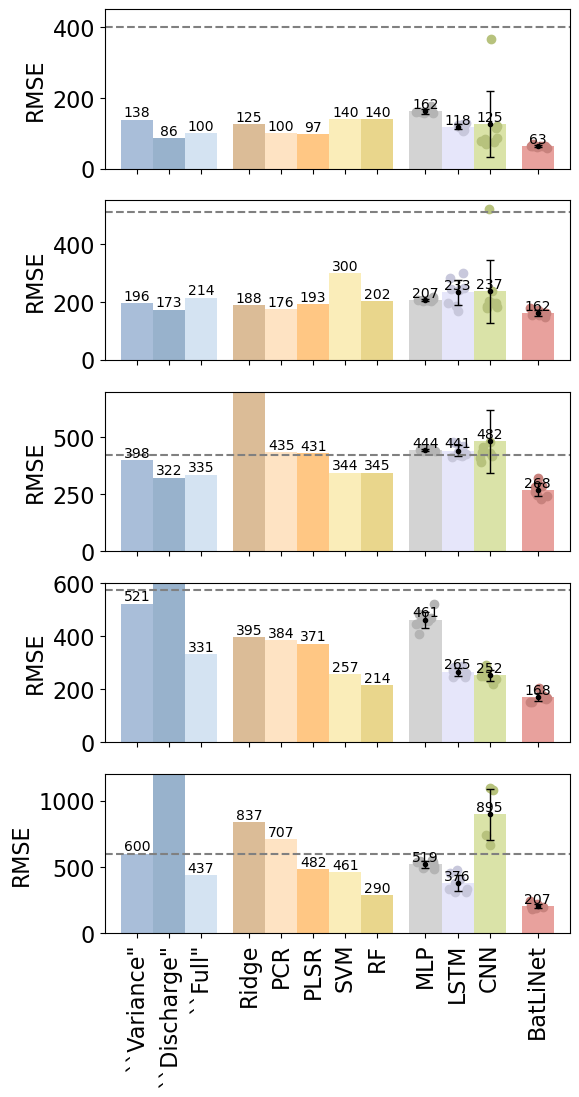

In [14]:
def ranged_random_float(x_min, x_max, size):
    x = np.random.rand(size)
    return x * (x_max - x_min) + x_min

fig, axes = plt.subplots(5, 1, figsize=(6, 12), sharex='col')
colors = [
    '#A9BED9', '#98B2CC', '#D4E3F2',  # Blues
     '#DBBC97', '#FEE3C3', '#FFC784', '#FAEDB9', 
    '#E9D68C', # Yellows
    '#D3D3D3', '#E6E6FA', '#DAE3A8',  # Low saturation colors
    # Red
    '#E8A19D'
]
color_to_dotcolor = {
    '#D3D3D3': '#B4B4B4',
    '#E6E6FA': '#C8C8DC',
    '#DAE3A8': '#B7C27D',
    '#E8A19D': '#C8827D'
}

def draw_points_around(ax, x, y, width, color):
    scatter_x = ranged_random_float(x - width * 0.3, x + width * 0.3, len(y))
    ax.scatter(scatter_x, y, color=color, zorder=2)


for ax, dataset in zip(axes, datasets_to_use):

    x, indx = 0, 0
    severson_baselines = ['variance_model', 'discharge_model', 'full_model']
    for method in severson_baselines:
        s = sklearn_baselines[dataset][method]
        ax.bar(x=x, height=s, width=1, color=colors[indx])
        ax.annotate(f'{s:.0f}', (x, s), ha='center', va='bottom', fontsize=10)
        x += 1
        indx += 1
    x += 0.5

    for method in ['ridge', 'pcr', 'plsr', 'svm', 'rf']:
        s = sklearn_baselines[dataset][method]
        ax.bar(x=x, height=s, width=1, color=colors[indx])
        ax.annotate(f'{s:.0f}', (x, s), ha='center', va='bottom', fontsize=10)
        x += 1
        indx += 1
    x += 0.5

    for method in ['mlp', 'lstm', 'cnn']:
        mean = np.mean(nn_baselines[dataset][method])
        std = np.std(nn_baselines[dataset][method])
        ax.bar(
            x=x,
            height=mean,
            width=1,
            color=colors[indx]
        )
        draw_points_around(
            ax,
            x,
            nn_baselines[dataset][method],
            width=1,
            color=color_to_dotcolor[colors[indx]]
        )
        ax.errorbar(
            x, mean, std,
            fmt='o',
            ecolor='black',
            color='black',
            elinewidth=1,
            capsize=3,
            markersize=3
        )
        ax.annotate(
            f'{mean:.0f}', (x, mean), ha='center', va='bottom', fontsize=10
        )
        x += 1
        indx += 1
    x += 0.5

    method = 'Ours'
    mean = np.mean(ours[dataset][method])
    std = np.std(ours[dataset][method])
    ax.bar(
        x=x,
        height=mean,
        width=1,
        color=colors[indx]
    )
    ax.annotate(
        f'{mean:.0f}', (x, mean), ha='center', va='bottom', fontsize=10
    )
    draw_points_around(
        ax,
        x,
        ours[dataset][method],
        width=1,
        color=color_to_dotcolor[colors[indx]]
    )
    ax.errorbar(
        x, mean, std,
        fmt='o',
        ecolor='black',
        color='black',
        elinewidth=1,
        capsize=3,
        markersize=3
    )

    # A dashed line for dummy model
    ax.hlines(
        y=[sklearn_baselines[dataset]['dummy']],
        xmin=-1,
        xmax=14,
        colors='gray',
        linestyle='dashed'
    )

ylims = [
    [0, 450],
    [0, 550],
    [0, 700],
    [0, 600],
    [0, 1200]
]

for indx, ax in enumerate(axes):
    ax.set_ylabel('RMSE')
    ax.set_xticks([
        0, 1, 2, 3.5, 4.5, 5.5, 6.5, 7.5, 9, 10, 11, 12.5
    ])
    ax.set_xticklabels([
        '``Variance"',
        '``Discharge"',
        '``Full"',
        'Ridge',
        'PCR',
        'PLSR',
        'SVM',
        'RF',
        'MLP',
        'LSTM',
        'CNN',
        'BatLiNet'
    ], rotation=90)
    ax.set_ylim(ylims[indx])
    ax.set_xlim([-1, 13.5])
os.makedirs(HOME / 'results/figures/fig3', exist_ok=True) 
plt.savefig(HOME / f'results/figures/fig3/RMSE.svg',
                bbox_inches='tight', pad_inches=0.1)
plt.show()

In [15]:
datasets_to_use = ['matr_1', 'matr_2', 'hust', 'mix_100', 'mix_20']
sklearn_baseline_names = [
    'dummy',
    'variance_model',
    'discharge_model',
    'full_model',
    'ridge',
    'pcr',
    'plsr',
    'svm',
    'rf'
]
nn_baseline_names = ['mlp', 'cnn', 'lstm']

def collect_results(dataset):
    sklearn_results = [
        sklearn_baselines[dataset][name] for name in sklearn_baseline_names
    ]
    nn_results = [
        nn_baselines[dataset][name] for name in nn_baseline_names
    ]
    our_results = [ours[dataset]['Ours']]
    return sklearn_results + nn_results + our_results

sklearn_baselines = defaultdict(dict)
for method_path in workspace.glob('baselines/sklearn/*'):
    method = method_path.name
    for dataset_res in method_path.glob('*'):
        dataset = dataset_res.name
        score = extract_scores(dataset_res / 'log.0')['MAPE']
        score = min(score, 120)  # For better visualizability
        sklearn_baselines[dataset][method] = score

nn_baselines = defaultdict(dict)
for method_path in workspace.glob('baselines/nn_models/*'):
    method = method_path.name
    for dataset_res in method_path.glob('*'):
        dataset = dataset_res.name
        scores = []
        for i in range(8):
            score = extract_scores(dataset_res / f'log.{i}')['MAPE']
            if score < 120:  # For better visualizability
                scores.append(score)
        nn_baselines[dataset][method] = scores
ours = defaultdict(dict)

method = 'Ours'
for dataset_res in workspace.glob('ablation/diff_branch/batlinet/*'):
    dataset = dataset_res.name
    try:
        scores = []
        for i in range(8):
            score = extract_scores(dataset_res / f'log.{i}')['MAPE']
            if score < 120:  # For better visualizability
                scores.append(score)
        ours[dataset][method] = scores
    except:
        ours[dataset][method] = 'none'

sklearn_baselines['matr_1']['variance_model'] = 15.
sklearn_baselines['matr_2']['variance_model'] = 12.
sklearn_baselines['matr_1']['discharge_model'] = 8.
sklearn_baselines['matr_2']['discharge_model'] = 11.
sklearn_baselines['matr_1']['full_model'] = 11.
sklearn_baselines['matr_2']['full_model'] = 12.
sklearn_baselines['matr_1']['ridge'] = 13.
sklearn_baselines['matr_2']['ridge'] = 11.
sklearn_baselines['matr_1']['pcr'] = 11.
sklearn_baselines['matr_2']['pcr'] = 11.
sklearn_baselines['matr_1']['plsr'] = 10.
sklearn_baselines['matr_2']['plsr'] = 11.
sklearn_baselines['matr_1']['rf'] = 15.
sklearn_baselines['matr_2']['rf'] = 11.


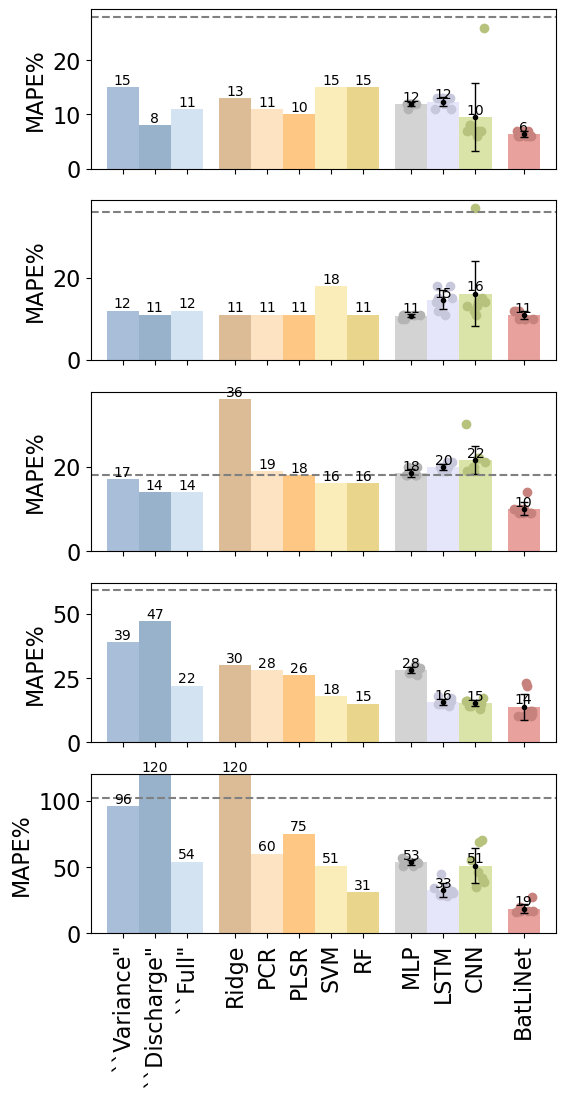

In [16]:
def ranged_random_float(x_min, x_max, size):
    x = np.random.rand(size)
    return x * (x_max - x_min) + x_min

fig, axes = plt.subplots(5, 1, figsize=(6, 12), sharex='col')
colors = [
    '#A9BED9', '#98B2CC', '#D4E3F2',  # Blues
     '#DBBC97', '#FEE3C3', '#FFC784', '#FAEDB9', 
    '#E9D68C', # Yellows
    '#D3D3D3', '#E6E6FA', '#DAE3A8',  # Low saturation colors
    # Red
    '#E8A19D'
]
color_to_dotcolor = {
    '#D3D3D3': '#B4B4B4',
    '#E6E6FA': '#C8C8DC',
    '#DAE3A8': '#B7C27D',
    '#E8A19D': '#C8827D'
}

def draw_points_around(ax, x, y, width, color):
    scatter_x = ranged_random_float(x - width * 0.3, x + width * 0.3, len(y))
    ax.scatter(scatter_x, y, color=color, zorder=2)


for ax, dataset in zip(axes, datasets_to_use):

    x, indx = 0, 0
    severson_baselines = ['variance_model', 'discharge_model', 'full_model']
    for method in severson_baselines:
        s = sklearn_baselines[dataset][method]
        ax.bar(x=x, height=s, width=1, color=colors[indx])
        ax.annotate(f'{s:.0f}', (x, s), ha='center', va='bottom', fontsize=10)
        x += 1
        indx += 1
    x += 0.5

    for method in ['ridge', 'pcr', 'plsr', 'svm', 'rf']:
        s = sklearn_baselines[dataset][method]
        ax.bar(x=x, height=s, width=1, color=colors[indx])
        ax.annotate(f'{s:.0f}', (x, s), ha='center', va='bottom', fontsize=10)
        x += 1
        indx += 1
    x += 0.5

    for method in ['mlp', 'lstm', 'cnn']:
        mean = np.mean(nn_baselines[dataset][method])
        std = np.std(nn_baselines[dataset][method])
        ax.bar(
            x=x,
            height=mean,
            width=1,
            color=colors[indx]
        )
        draw_points_around(
            ax,
            x,
            nn_baselines[dataset][method],
            width=1,
            color=color_to_dotcolor[colors[indx]]
        )
        ax.errorbar(
            x, mean, std,
            fmt='o',
            ecolor='black',
            color='black',
            elinewidth=1,
            capsize=3,
            markersize=3
        )
        ax.annotate(
            f'{mean:.0f}', (x, mean), ha='center', va='bottom', fontsize=10
        )
        x += 1
        indx += 1
    x += 0.5

    method = 'Ours'
    mean = np.mean(ours[dataset][method])
    std = np.std(ours[dataset][method])
    ax.bar(
        x=x,
        height=mean,
        width=1,
        color=colors[indx]
    )
    ax.annotate(
        f'{mean:.0f}', (x, mean), ha='center', va='bottom', fontsize=10
    )
    draw_points_around(
        ax,
        x,
        ours[dataset][method],
        width=1,
        color=color_to_dotcolor[colors[indx]]
    )
    ax.errorbar(
        x, mean, std,
        fmt='o',
        ecolor='black',
        color='black',
        elinewidth=1,
        capsize=3,
        markersize=3
    )

    # A dashed line for dummy model
    ax.hlines(
        y=[sklearn_baselines[dataset]['dummy']],
        xmin=-1,
        xmax=14,
        colors='gray',
        linestyle='dashed'
    )

for indx, ax in enumerate(axes):
    ax.set_ylabel('MAPE%')
    ax.set_xticks([
        0, 1, 2, 3.5, 4.5, 5.5, 6.5, 7.5, 9, 10, 11, 12.5
    ])
    ax.set_xticklabels([
        '``Variance"',
        '``Discharge"',
        '``Full"',
        'Ridge',
        'PCR',
        'PLSR',
        'SVM',
        'RF',
        'MLP',
        'LSTM',
        'CNN',
        'BatLiNet'
    ], rotation=90)
    ylim = ax.get_ylim()
    ax.set_ylim([ylim[0], min(ylim[1], 120)])
    ax.set_xlim([-1, 13.5])
plt.savefig(HOME / f'results/figures/fig3/MAPE.svg',
            bbox_inches='tight', pad_inches=0.1)
plt.show()


Reproduce Figure 4. (Refer to transfer_exp.ipynb)

Reproduce Figure 5a.


/tmp/ipykernel_3541125/3233883649.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_file))
Looping through all test cells: 100%|████

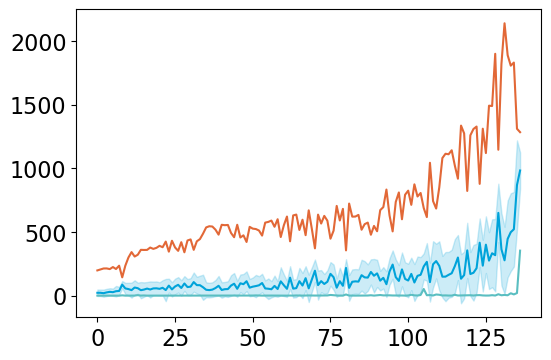

In [30]:
from torch.utils.data import DataLoader
# Load the data from the predictions
# For all seeds, do
# 1. load the checkpoint
# 2. manually run forward, get the per-support instance predictions
path = Path('../workspaces/ablation/diff_branch/batlinet/mix_100')
# device = 'cuda:0'
device = 'cpu'
in_C, C, H, W = 6, 32, 100, 1000
model = MODELS.build({
    'name': 'BatLiNetRULPredictor',
    'in_channels': in_C,
    'channels': C,
    'input_height': H,
    'input_width': W,
    'support_size': 1,
    'test_batch_size': 1,
    'return_pointwise_predictions': True
})
ckpt_file = next(path.glob(f'*_0_epoch_1000.ckpt'))
model.load_state_dict(torch.load(ckpt_file))
model = model.to(device)
model.eval()

pred_file = next(path.glob(f'*seed_0_*.pkl'))
with open(pred_file, 'rb') as f:
    preds = pickle.load(f)
    data = preds['data']

# For each test cell, run prediction using each train cell as reference.
errors = []
test_dataset = model.build_cycle_diff_dataset(data.test_data)
test_dataset.feature = test_dataset.feature.to(device)
test_dataset.raw_feature = test_dataset.raw_feature.to(device)
test_dataset.label = test_dataset.label.to(device)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
for sample in tqdm(test_loader, desc='Looping through all test cells'):
    x, y, raw_x = sample.values()
    train_feat = data.train_data.feature.clone().to(device)
    train_label = data.train_data.label.clone().to(device)
    preds = []
    for i in range(len(data.train_data.feature)):
        sup_x, sup_y = model.get_support_set(
            raw_x, train_feat[i][None], train_label[i][None]
        )
        preds.append(model(x, y, sup_x, sup_y)[1])
    preds = data.label_transformation.inverse_transform(torch.cat(preds).cpu())
    label = data.label_transformation.inverse_transform(y.cpu())
    errors.append(abs(preds - label))

errors = np.array(errors)
# For each cell, find the optimal support and the worst support, and the median±std
bests, worsts, medians, stds = [], [], [], []
for cell_res in errors:
    bests.append(min(cell_res))
    worsts.append(max(cell_res))
    medians.append(np.median(cell_res))
    stds.append(np.std(cell_res))
bests = np.array(bests).reshape(-1)
worsts = np.array(worsts).reshape(-1)
medians = np.array(medians).reshape(-1)
stds = np.array(stds).reshape(-1)

order = np.argsort(medians * 0.7 + worsts * 0.3)
bests, worsts, medians, stds = bests[order], worsts[order], medians[order], stds[order]


colors = ['#00A3DA', '#E26837', '#5ABEC1']
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

x = np.arange(len(bests))
plt.plot(x, worsts, color=colors[1])
plt.plot(x, bests, color=colors[2])
plt.fill_between(
    x, medians - stds, medians + stds, alpha=0.2, color=colors[0]
)
plt.plot(x, medians, color=colors[0])
os.makedirs(HOME / 'results/figures/fig5', exist_ok=True)
fig.savefig(HOME / f'results/figures/fig5/5a_sup_choice_mix_100.svg',
            bbox_inches='tight', pad_inches=0.1, transparent=True)
plt.show()

Reproduce Figure 5b.

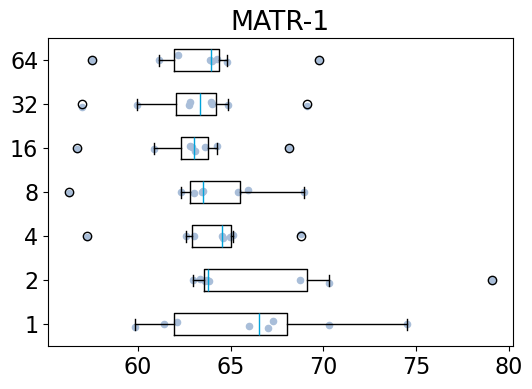

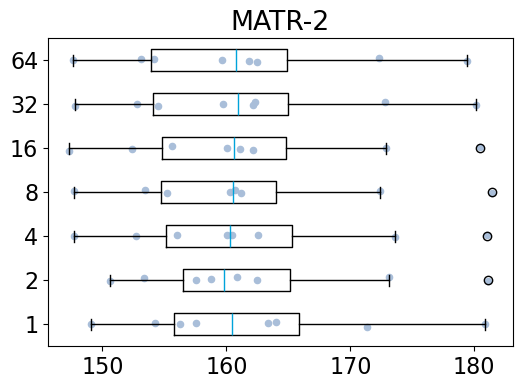

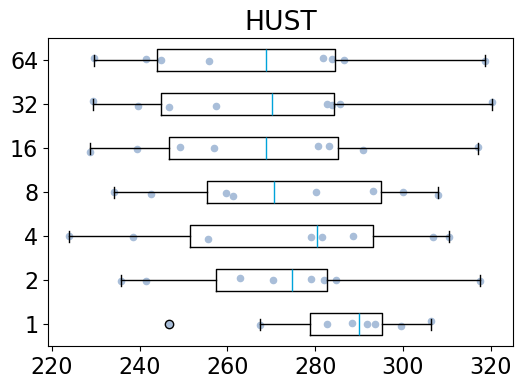

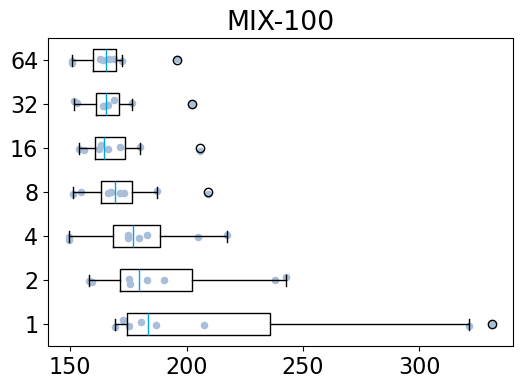

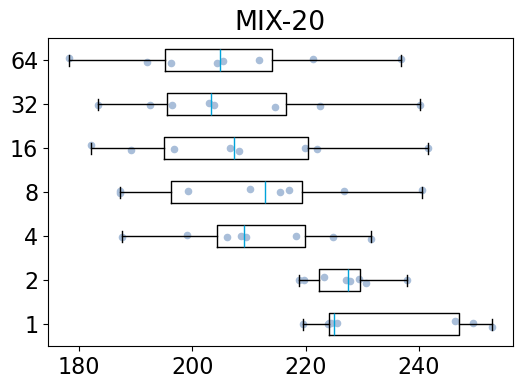

In [18]:
method_names = ['BatLiNet', 'Cell-difference only', 'Cycle-difference only']
datasets = ['matr_1', 'matr_2', 'hust', 'mix_100', 'mix_20']
dataset_names = ['MATR-1', 'MATR-2', 'HUST', 'MIX-100', 'MIX-20']
path = Path('../workspaces/ablation/test_support_size/')
colors = ['#00A3DA', '#5ABEC1', '#E26837']
sup_sizes = [1, 2, 4, 8, 16, 32, 64]
for dataset, dataset_name in zip(datasets, dataset_names):
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    curves = []
    for sup_size in sup_sizes:
        model_path = path / str(sup_size) / dataset
        scores = []
        for log_path in model_path.glob('log.*'):
            with open(log_path, 'r') as f:
                rmse = float(re.findall('RMSE: (.*?) ', f.read())[0])
            scores.append(rmse)
        curves.append(scores)
    to_plot = np.array(curves).T
    ax.boxplot(to_plot, medianprops=dict(color=colors[0]), vert=False)

    for i, data in enumerate(to_plot.T):
        y = np.random.normal(i + 1, 0.04, size=len(data))  # Add some jitter for better visibility
        ax.scatter(data, y, alpha=1, s=20, color='#A9BED9')

    if dataset == 'mix':
        xlim = ax.get_xlim()
        ax.set_xlim([143, 189])

    ax.set_title(dataset_name)
    ax.set_yticks(np.arange(1, 8), labels=sup_sizes)
    # ax.set_yticklabels([])
    # ax.set_xticklabels([])
    if dataset_name == 'MIX-100':
        fig.savefig(HOME / f'results/figures/fig5/5b_test_sup_size_{dataset_name}.svg',
                    bbox_inches='tight', pad_inches=0.1, transparent=True)
    plt.show()



Reproduce Figure 5c.

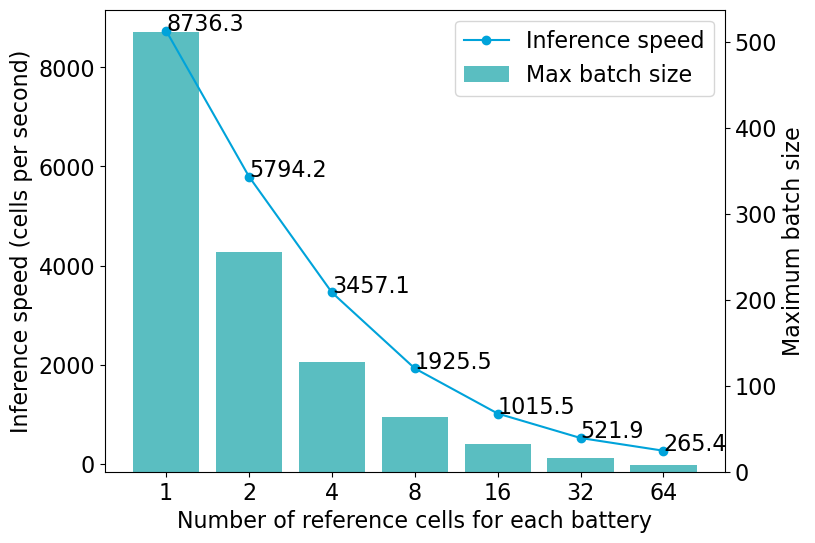

In [29]:


# import inspect
# from torch.utils import benchmark

# def var_dict(*args):
#     callers_local_vars = inspect.currentframe().f_back.f_locals.items()
#     return dict([
#         (name, val) for name, val in callers_local_vars if val is arg
#     ][0] for arg in args)

# def walltime(stmt, arg_dict, duration=3):
#     timer = benchmark.Timer(stmt=stmt, globals=arg_dict)\
#                      .blocked_autorange(min_run_time=duration)
#     return timer

# # device = 'cuda:0'
# device = 'cpu'
# in_C, C, H, W = 6, 32, 100, 1000

# model = MODELS.build({
#     'name': 'BatLiNetRULPredictor',
#     'in_channels': in_C,
#     'channels': C,
#     'input_height': H,
#     'input_width': W
# })
# model = model.to(device).half()
# model.eval()

sup_sizes = [1, 2, 4, 8, 16, 32, 64]
batch_sizes = np.array([128, 64, 32, 16, 8, 4, 2]) * 4
# results = []
# with torch.no_grad():
#     for sup_size, batch_size in zip(sup_sizes, batch_sizes):
#         x = torch.rand([batch_size, in_C, H, W], device=device).half()
#         sup_x = torch.rand([batch_size, sup_size, in_C, H, W], device=device).half()
#         y = torch.rand([batch_size, 1], device=device).half()
#         sup_y = torch.rand([batch_size, sup_size, 1], device=device).half()
#         t = walltime(
#             'model(x, y, sup_x, sup_y)', var_dict(model, x, y, sup_x, sup_y))
#         max_, min_, med = max(t.times), min(t.times), t.median
#         results.append((batch_size / med, batch_size / max_, batch_size / min_))
#         del x, sup_x, y, sup_y

colors = ['#00A3DA', '#5ABEC1']
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
tax = ax.twinx()

# print([res[0] for res in results])
# Since Code Ocean's machine only has a CPU, it is unable to reproduce the results of GPU 4090, so only the results of 4090 are shown.
results = [[8736.3],[5794.2],[3457.1],[1925.5], [1015.5], [521.9], [265.4]]

x = np.arange(len(results))
tax.bar(x, batch_sizes, color=colors[1], label='Max batch size')
ax.set_xticks(np.arange(len(results)), sup_sizes)
ax.plot(
    x, [res[0] for res in results], 'o-',
    color=colors[0], label='Inference speed')
# ax.fill_between(
#     x, [res[1] for res in results],
#     [res[2] for res in results],
#     alpha=0.2, color=colors[0], zorder=2)
ax.set_zorder(tax.get_zorder()+1)
ax.set_frame_on(False)

for i, num in enumerate(results):
    ax.text(i, num[0], f'{num[0]:.1f}')

ax.set_ylabel('Inference speed (cells per second)')
tax.set_ylabel('Maximum batch size')
ax.set_xlabel('Number of reference cells for each battery')

handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = tax.get_legend_handles_labels()
handles = handles1 + handles2
labels = labels1 + labels2

leg = ax.legend(handles, labels)

# tax.set_ylim([0, 180])
# ax.set_ylim([0, 3500])
# ax.set_yticklabels([])
# ax.set_xticklabels([])
fig.savefig(HOME / f'results/figures/fig5/5c_running_time_half_precision_with_text.svg',
            bbox_inches='tight', pad_inches=0.1, transparent=True)
plt.show()

Reproduce Supp Figure 3.

In [20]:
from itertools import chain

cycle = 99

for cell in tqdm(
    chain(*material_map.values()),
    desc='Calculating features and labels',
    total=sum(len(x) for x in material_map.values())
):

    feat = get_V_of_Qd(cell.cycle_data[cycle], cell.nominal_capacity_in_Ah)
    label = get_cycle_life(cell)
    cell.feature, cell.label = feat, label

Calculating features and labels: 100%|██████████| 403/403 [00:03<00:00, 105.02it/s]


In [21]:
def least_squares_loss(x, y):
    if len(x) != len(y):
        raise ValueError("The length of x and y must be the same.")
    
    n = len(x)
    mean_x = sum(x) / n
    mean_y = sum(y) / n
    
    numerator = sum((xi - mean_x) * (yi - mean_y) for xi, yi in zip(x, y))
    denominator = sum((xi - mean_x) ** 2 for xi in x)
    
    if denominator == 0:
        raise ValueError("Variance of x is zero, cannot fit a linear model.")
    
    b = numerator / denominator
    a = mean_y - b * mean_x
    
    loss = sum((yi - (a + b * xi)) ** 2 for xi, yi in zip(x, y))
    
    return loss, b, a

def get_x(feat_a, feat_b):
    return np.log(np.nanstd(feat_a - feat_b) + 1)

def calculate_r_squared(y_true, y_pred):
    """
    Calculate the R-squared (coefficient of determination) for a set of observed and predicted values.

    Parameters:
    y_true (array-like): Array of observed values (actual data).
    y_pred (array-like): Array of predicted values (predicted by a model).

    Returns:
    float: The R-squared value.
    """
    # Convert input to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate the total sum of squares (SS_tot)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    
    # Calculate the residual sum of squares (SS_res)
    ss_res = np.sum((y_true - y_pred) ** 2)
    
    # Calculate R-squared
    r_squared = 1 - (ss_res / ss_tot)
    
    return r_squared

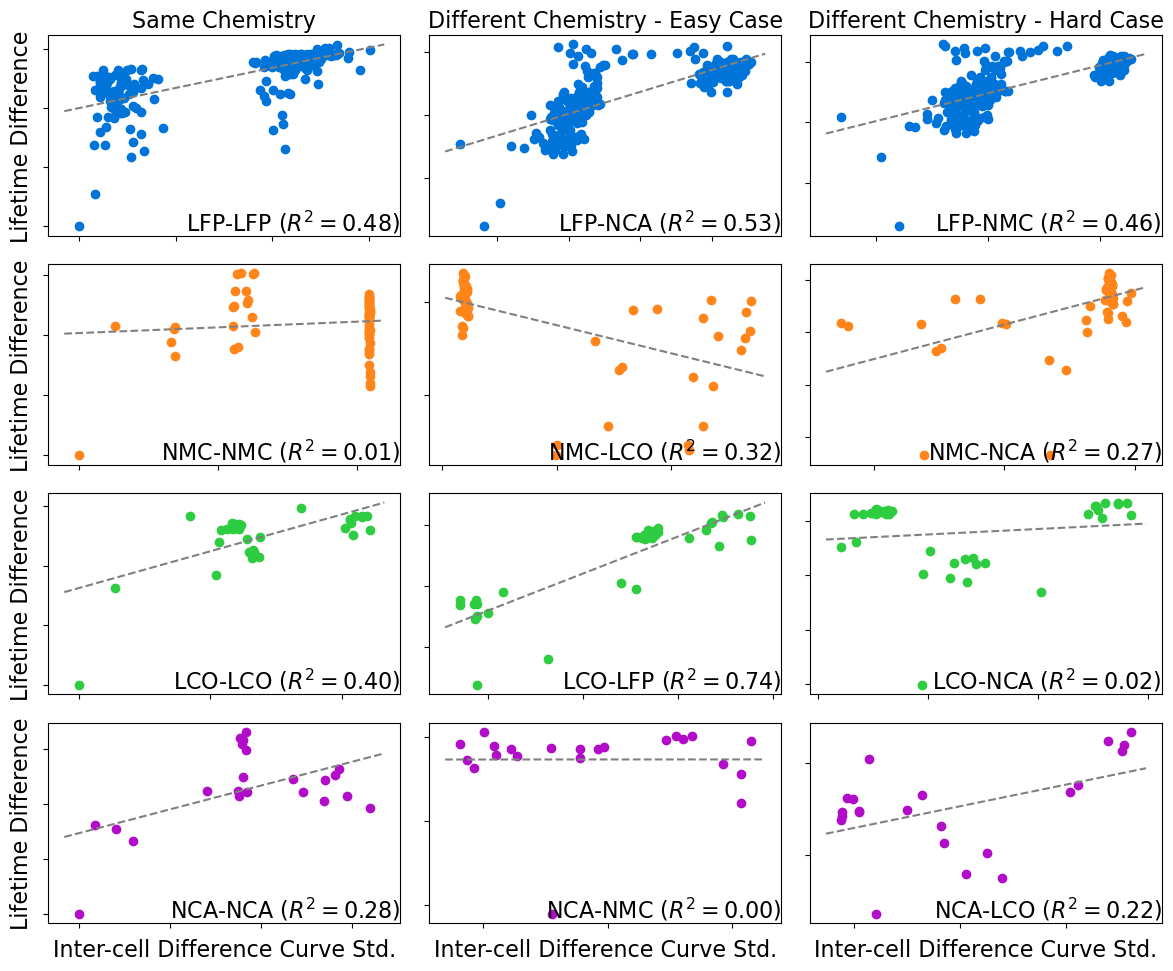

In [22]:
from itertools import product

material_pairs = (
    (('LFP', 'LFP'), ('LFP', 'NCA'), ('LFP', 'NMC')),
    (('NMC', 'NMC'), ('NMC', 'LCO'), ('NMC', 'NCA')),
    (('LCO', 'LCO'), ('LCO', 'LFP'), ('LCO', 'NCA')),
    (('NCA', 'NCA'), ('NCA', 'NMC'), ('NCA', 'LCO')),
)
ref_cell_index = (
    (47, 7, 57),
    (68, 21, 11),
    (1, 266, 12),
    (3, 65, 27)
)
fig, axes = plt.subplots(len(material_map), 3, figsize=(12, 10))

for i, j in product(range(len(axes)), range(len(axes[0]))):
    (mat, ref_mat), ax, ref_indx = material_pairs[i][j], axes[i, j], ref_cell_index[i][j]
    mat_features = [cell.feature for cell in material_map[mat]]
    mat_labels = [cell.label for cell in material_map[mat]]
    ref_cell = material_map[ref_mat][ref_indx]
    x = [get_x(ref_cell.feature, f) for f in mat_features]
    y = [np.log(abs(ref_cell.label - l) + 1) for l in mat_labels]

    _, w, b = least_squares_loss(x, y)

    ax.scatter(x, y, color=palette[i])
    xlim, ylim = ax.get_xlim(), ax.get_ylim()
    x = np.linspace(*xlim, 1000)
    y = w * x + b
    ax.plot(x, y, color='grey', linestyle='--')

for ax in axes.reshape(-1):
    ax.set_xticklabels([])
    ax.set_yticklabels([])
axes[0, 0].set_title('Same Chemistry', fontsize=16)
axes[0, 1].set_title('Different Chemistry - Easy Case', fontsize=16)
axes[0, 2].set_title('Different Chemistry - Hard Case', fontsize=16)
for i in range(len(axes)):
    axes[i, 0].set_ylabel('Lifetime Difference')
for j in range(len(axes[0])):
    axes[-1, j].set_xlabel('Inter-cell Difference Curve Std.')
plt.tight_layout()

for i, j in product(range(len(axes)), range(len(axes[0]))):
    (mat, ref_mat), ax, ref_indx = material_pairs[i][j], axes[i, j], ref_cell_index[i][j]
    xlim, ylim = ax.get_xlim(), ax.get_ylim()
    mat_features = [cell.feature for cell in material_map[mat]]
    mat_labels = [cell.label for cell in material_map[mat]]
    ref_cell = material_map[ref_mat][ref_indx]
    x = np.array([get_x(ref_cell.feature, f) for f in mat_features])
    y = np.array([np.log(abs(ref_cell.label - l) + 1) for l in mat_labels])
    _, w, b = least_squares_loss(x, y)
    y_pred = w * x + b

    score = calculate_r_squared(y, y_pred)

    ax.text(
        xlim[1], ylim[0], f'{mat}-{ref_mat} ($R^2=${score:.2f})',
        horizontalalignment='right',
        verticalalignment='bottom'
    )
os.makedirs(HOME / 'results/figures/supp3', exist_ok=True)
fig.savefig(HOME / f'results/figures/supp3/detailed_comparison_cross_chemistry.svg',
            bbox_inches='tight', pad_inches=0.1, transparent=True)
plt.show()

Reproduce Supp Figure 4a.

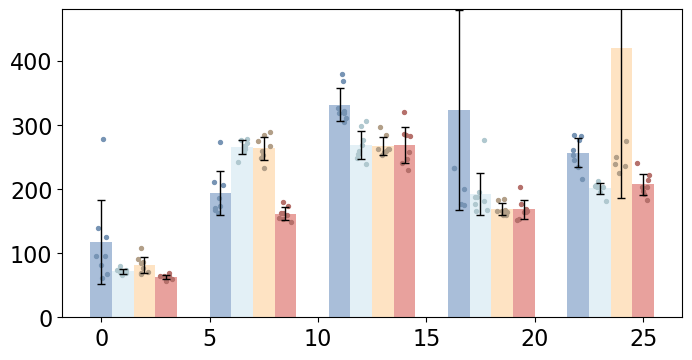

In [23]:
base_path = Path('../workspaces/ablation/diff_branch/')
methods = ['cycle_diff_only', 'cell_diff_only', 'naive_ensemble', 'batlinet']
datasets = ['matr_1', 'matr_2', 'hust', 'mix_100', 'mix_20']
dataset_names = ['MATR-1', 'MATR-2', 'HUST', 'MIX-100', 'MIX-100']
width = 1
fig, ax = plt.subplots(figsize=(8, 4))
# colors = ['#E98355', '#5ABEC1', '#E6766D', '#00A3DA']
colors = ['#A9BED9', '#E3F0F6', '#FEE3C3', '#E8A19D']

dot_colors = ['#7794B4', '#B0C8CF', '#b29f88', '#B5706B']
for indx, (method, color) in enumerate(zip(methods, colors)):
    to_plot = []
    for dataset, dataset_name in zip(datasets, dataset_names):
        path = base_path / method / dataset
        rmses = []
        for log in path.glob('log.*'):
            with open(log, 'r') as f:
                rmse = re.findall('RMSE: (.*?) ', f.read())
            rmses.append(rmse)
        if len(rmses) < 8:
            print(rmses)
            rmses = rmses + [['nan']] * (8 - len(rmses))
        to_plot.append(rmses)
    to_plot = np.array(to_plot, dtype=float)
    means, stds = np.nanmean(to_plot, axis=1), np.nanstd(to_plot, axis=1)
    x = np.arange(len(datasets))
    x = x * (len(methods)+1.5) + indx
    
    ax.bar(x, means.reshape(-1),
           width=width,
           color=color,
           yerr=stds.reshape(-1),
           error_kw=dict(capsize=3, capthick=1, lw=1),
           # error bar color is darker than grey
           ecolor='black')
    fluctuation = 0.3
    
    for i in range(to_plot.shape[1]):
        x_positions = x + np.random.uniform(-fluctuation, fluctuation, size=len(x))
        ax.scatter(x_positions, to_plot[:, i], color=dot_colors[indx], zorder=1, s=8)

    # ax.set_xticks(np.arange(1.5, 28, 5.5), [])
    ax.set_ylim([0, 480])
# ax.set_yticklabels([])
os.makedirs(HOME / 'results/figures/supp4', exist_ok=True)
fig.savefig(HOME / f'results/figures/supp4/4a_branch_ablation.svg',
            bbox_inches='tight', pad_inches=0.1, transparent=True)
plt.show()

Reproduce Supp Figure 4b.

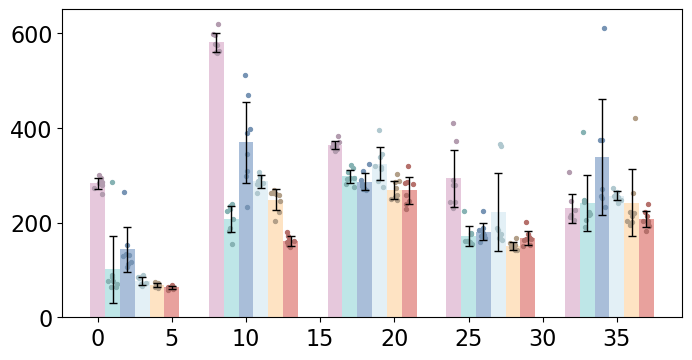

In [24]:
features = [
    'current_only', 'voltage_only',
    'charge_only', 'discharge_only',
    'raw_signals_only', 'all_features'
]
datasets = [
    'matr_1', 'matr_2', 'hust', 'mix_100', 'mix_20'
]
colors = ['#E6C8DC', '#BEE6E7', '#A9BED9', '#E3F0F6', '#FEE3C3', '#E8A19D']
dot_colors = ['#b39caf', '#86b2b3', '#7794B4', '#B0C8CF', '#b29f88', '#B5706B']

path = Path('../workspaces/ablation/feature_spaces')

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
for indx, (feature, color) in enumerate(zip(features, colors)):
    to_plot = []
    for dataset in datasets:
        feature_path = path / feature / dataset
        rmses = []
        for log in feature_path.glob('log.*'):
            with open(log, 'r') as f:
                rmse = re.findall('RMSE: (.*?) ', f.read())[0]
            if float(rmse) > 1000:
                rmses.append('nan')
            else:
                rmses.append(rmse)
        to_plot.append(rmses)
    to_plot = np.array(to_plot, dtype=float)
    means, stds = np.nanmean(to_plot, axis=1), np.nanstd(to_plot, axis=1)
    x = np.arange(len(datasets))
    x = x * (len(features)+2) + indx
    ax.bar(x, means.reshape(-1),
           width=1,
           color=color,
           yerr=stds.reshape(-1),
           error_kw=dict(capsize=3, capthick=1, lw=1),
           # error bar color is darker than grey
           ecolor='black')
    fluctuation = 0.3
    for i in range(to_plot.shape[1]):
        x_positions = x + np.random.uniform(-fluctuation, fluctuation, size=len(x))
        ax.scatter(x_positions, to_plot[:, i], color=dot_colors[indx],zorder=1, s=8)
    # ax.set_xticks(np.arange(2.5, 42, 8), [])
    # ax.set_ylim([0, 480])
# ax.set_yticklabels([])
fig.savefig(HOME / f'results/figures/supp4/4b_feature_ablation.svg', bbox_inches='tight', pad_inches=0.1)
plt.show()

Reproduce Supp Figure 5a.

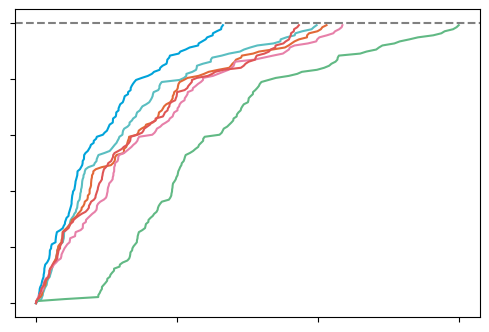

In [25]:
paths = [
    '../workspaces/ablation/diff_branch/batlinet/mix_100',
    '../workspaces/baselines/nn_models/cnn/mix_100',
    '../workspaces/baselines/nn_models/lstm/mix_100',
    '../workspaces/baselines/nn_models/mlp/mix_100',
    '../workspaces/baselines/sklearn/svm/mix_100',
    '../workspaces/baselines/sklearn/rf/mix_100',
]
methods = ['BatLiNet', 'CNN', 'LSTM', 'MLP', 'SVM', 'RF']
# colors = ['#00A3DA', '#E26837', '#5ABEC1', ]
colors = ['#00A3DA', '#5ABEC1', '#E26837', '#61B984', '#E780A9', '#DF5555']

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

for path, method, color in zip(paths, methods, colors):
    path = Path(path)
    pred_path = next(path.glob('pred*.pkl'))
    with open(pred_path, 'rb') as f:
        preds = pickle.load(f)
    label_tf = preds['data'].label_transformation
    labels = label_tf.inverse_transform(preds['data'].test_data.label.cpu())
    preds = label_tf.inverse_transform(preds['prediction'].cpu())
    # error, _ = (labels - preds).abs().sort()
    error = (labels - preds).abs()
    error = torch.cat([torch.tensor([0]), error, ])
    x = np.arange(len(error)) / len(error)
    ax.plot(torch.cumsum(error, 0) / 1000, x, label=method, color=color)

xlim, ylim = ax.get_xlim(), ax.get_ylim()
ax.hlines([1], xlim[0], xlim[1], color='grey', linestyles='dashed')
ax.set_xlim(xlim)
# plt.legend()
ax.set_yticklabels([])
ax.set_xticklabels([])
os.makedirs(HOME / 'results/figures/supp5', exist_ok=True)
fig.savefig(HOME / f'results/figures/supp5/5a_cum_error_with_text.svg', bbox_inches='tight', pad_inches=0.1)
plt.show()

Reproduce Supp Figure 5b-f.

Err within 10%: tensor(0.7619)
Err within 20%: tensor(1.)


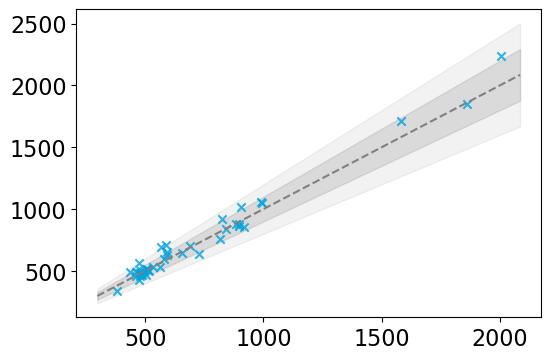

Err within 10%: tensor(0.5500)
Err within 20%: tensor(0.8750)


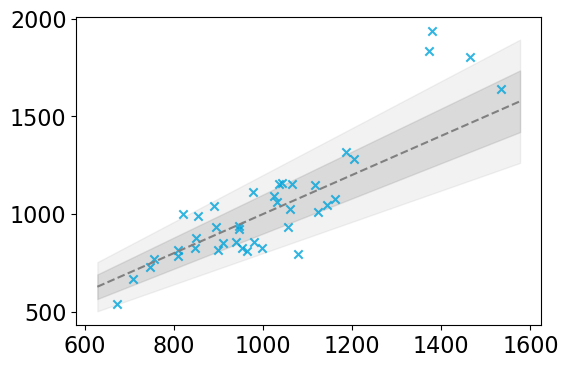

Err within 10%: tensor(0.7273)
Err within 20%: tensor(0.8636)


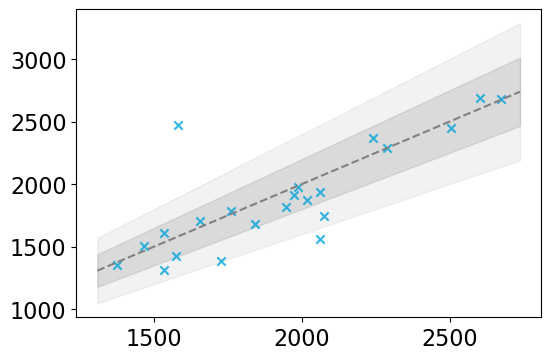

Err within 10%: tensor(0.3605)
Err within 20%: tensor(0.7007)


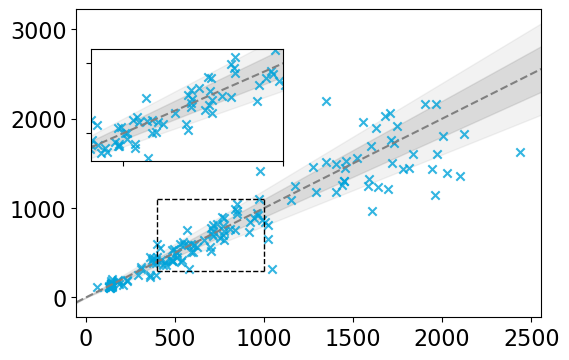

Err within 10%: tensor(0.6788)
Err within 20%: tensor(0.8905)


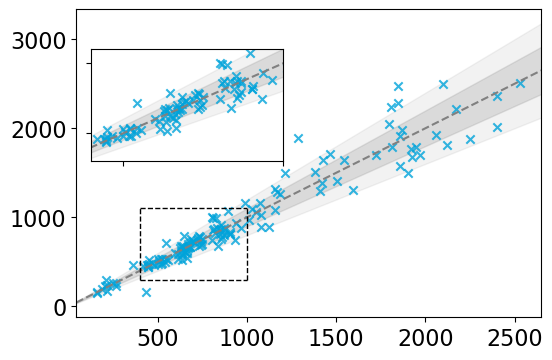

In [26]:
method_names = ['BatLiNet', 'Cell-difference only', 'Cycle-difference only']
datasets = ['matr_1', 'matr_2', 'hust', 'mix_20', 'mix_100']
dataset_names = ['MATR-1', 'MATR-2', 'HUST', 'MIX-20', 'MIX-100']
method_paths = [
    '../workspaces/ablation/diff_branch/batlinet/',
    '../workspaces/ablation/diff_branch/cell_diff_only/',
    '../workspaces/ablation/diff_branch/cycle_diff_only/',
]
colors = ['#00A3DA', '#5ABEC1', '#E26837']
markers = ['x', 'o', '^']
boxes = [
    # [[400, 1000], [300, 1100]],
    # [[420, 700], [400, 700]],
    None,
    None,
    None,
    [[400, 1000], [300, 1100]],
    [[400, 1000], [300, 1100]],
]
for dataset, dataset_name, box_to_show in zip(datasets, dataset_names, boxes):
    paths = [Path(x+dataset) for x in method_paths]
    for method, method_path, color, marker in zip(
        method_names, paths, colors, markers
    ):
        fig, ax = plt.subplots(1, 1, figsize=(6, 4))
        if box_to_show is not None:
            ax2 = fig.add_axes([0.15, 0.5, 0.32, 0.28])
        data = next(method_path.glob('*seed_0_*.pkl'))
        with open(data, 'rb') as f:
            data = pickle.load(f)
            pred = data['data'].label_transformation.inverse_transform(
                data['prediction'].to('cpu'))
            label = data['data'].label_transformation.inverse_transform(
                data['data'].test_data.label.to('cpu'))
        # pred, label = pred.log(), label.log()
        ax.scatter(pred, label, color=color, marker=marker, alpha=0.8)
        if box_to_show is not None:
            ax2.scatter(pred, label, color=color, marker=marker, alpha=0.8)
        # Plot y=x in grey color, dashed and alpha is 0.5
        xlim = ax.get_xlim()
        x = torch.linspace(*xlim, 100)
        # x = np.linspace(label.min(), label.max(), 100)
        ax.plot(x, x, color='grey', linestyle='--')
        if box_to_show is not None:
            ax2.plot(x, x, color='grey', linestyle='--')
        # # Plot the x% error area, filled with grey, low alpha and zorder
        range_ = 10 / 100
        y1 = (1 - range_) * x
        y2 = (1 + range_) * x
        ax.fill_between(x, y1, y2, color='grey', alpha=0.2, zorder=-1)
        print(
            'Err within 10%:',
            ((pred > label * 0.9) & (pred < label * 1.1)).sum() / len(pred))
        if box_to_show is not None:
            ax2.fill_between(x, y1, y2, color='grey', alpha=0.2, zorder=-1)
        range_ = 20 / 100
        y1 = (1 - range_) * x
        y2 = (1 + range_) * x
        ax.fill_between(x, y1, y2, color='grey', alpha=0.1, zorder=-1)
        print(
            'Err within 20%:',
            ((pred > label * 0.8) & (pred < label * 1.2)).sum() / len(pred))
        if box_to_show is not None:
            ax2.fill_between(x, y1, y2, color='grey', alpha=0.1, zorder=-1)

        if box_to_show is not None:
            ax.vlines(box_to_show[0], *box_to_show[1],
                      linewidth=1, linestyle='--', color='black')
            ax.hlines(box_to_show[1], *box_to_show[0],
                      linewidth=1, linestyle='--', color='black')
            ax.set_xlim(xlim)

            ax2.set_xlim(box_to_show[0])
            ax2.set_ylim(box_to_show[1])
            ax2.set_xticklabels([])
            ax2.set_yticklabels([])

        fig.savefig(HOME / f'results/figures/supp5/instance_level_err_{dataset_name}.svg',
                    bbox_inches='tight', pad_inches=0.1, transparent=True)
        break
    plt.show()
